In [37]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.optimize as spo
from hmmlearn.hmm import GaussianHMM
import random
import pandas as pd
import numpy.random as rnd


np.random.seed(675)

In [38]:
def generate_state(mat_transition, n):
    x=np.arange(n)
    x[0]=0
    dim=len(mat_transition[0])
    for i in np.arange(1,n):
        x[i]=rnd.choice(a=dim,p=mat_transition[x[i-1]])
    return x

In [39]:
u1_v = 1
u2_v = 6

#Step 1: We initiate the data
p11= random.random()+0.0001
p22 = random.random() + 0.0001

p11= 0.9
p22=0.9
p12 = 1 - p11
p21 = 1 - p22     
sig =1
        
t=1000

transmat = [[p11,p12],[p21,p22]]
params=[u1_v,u2_v,sig, p11,p22]

In [40]:
# Generate thes returns
def generateRet(params,x):
    
    st = []
    T=len(x)
    u1_v = params[0]
    u2_v= params[1]
    sig = params[2]
    
    
    u1 = np.random.normal(u1_v, sig, T)
    u2 = np.random.normal(u2_v, sig, T)
    #Faire un tirage aléatoire
    
    st0 = 0.5*u1[0] + 0.5 * u2[0]

    #Since we start in state 0, we add st0
    st.append(st0)

    for i in range(1,T):

        if (x[i] == 0):
            st.append(u1[i])
        else:
            st.append(u2[i])

    return st

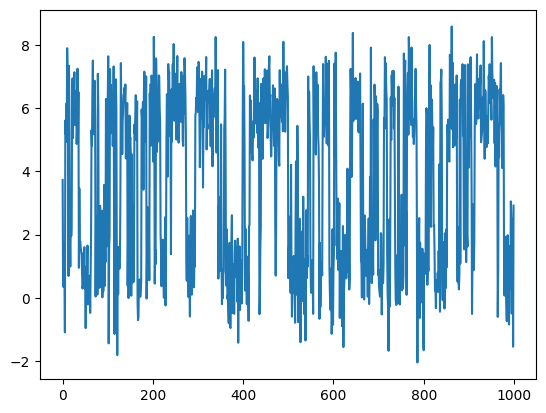

In [41]:
x = generate_state(transmat, t)

y = generateRet(params,x)

x = np.arange(0, len(y))
plt.plot(x,y)


In [42]:
#generates probility
def generate_p(params,y) :
    p1filt = np.zeros(len(y))
    p2filt = np.zeros(len(y))
    p1_prev = np.zeros(len(y))
    p2_prev = np.zeros(len(y))
    fyt_global = np.zeros(len(y))

    u1 = params[0]
    u2= params[1]
    sig = params[2]
    p11=params[3]
    p22 = params[4]
  
    p21 = 1 - p22
    p12 = 1 - p11


    #we initialize
    p1filt[0] = ((1 - p22) / (2 - p11 - p22))
    p2filt[0] = ((1 - p11) / (2 - p11 - p22))


    for t in range(1, len(y)) : 
        #etape 1
        p1_prev[t] = p1filt[t-1] * p11 + p2filt[t-1] * p21
        p2_prev[t] = p1filt[t-1] * p12 + p2filt[t-1] * p22
        
        
        fyt_global[t] = 1/(math.sqrt(2*np.pi*sig))*math.exp(-1*(y[t]-u1)**2/(2*sig))*p1_prev[t] + 1/(math.sqrt(2*np.pi*sig))*math.exp(-1*(y[t]-u2)**2/(2*sig))*p2_prev[t]
    
        p1filt[t] = (1/(math.sqrt(2*np.pi*sig)))*math.exp(-1*(y[t]-u1)**2/(2*sig))* p1_prev[t] / fyt_global[t]
        p2filt[t] = (1/(math.sqrt(2*np.pi*sig)))*math.exp(-1*(y[t]-u2)**2/(2*sig))* p2_prev[t] / fyt_global[t]

    return p1filt,p2filt


In [43]:
#Function to create HMM des probabilité fil trouvé préalablement
def hmm(p1filt, p2filt) :
    hmm = np.zeros(len(p1filt))
    for i in range(0, len(p1filt)-1):
        if p1filt[i] > p2filt[i]:
            hmm[i] = 0
        elif p1filt[i] == p2filt[i]:
            hmm[i]= 0.5
        else: hmm[i] = 1
    return hmm

In [44]:
def find_transition(hmm):
    mt11 = 0
    mt12 = 0
    mt21 = 0
    mt22 = 0
    for m in range(len(hmm)-1):
        
        
        if hmm[m] == 0 :
            if hmm[m+1]  == 0:
                mt11 = mt11 + 1
            else : 
                mt12 =  mt12 + 1
        else:
            if hmm[m+1]  == 0:
                mt21 = mt21 + 1
            else : 
                mt22 = mt22 + 1
    
    sum_all1 = mt11 + mt12 
    sum_all2 = mt21 + mt22  
    
    matrice_transition_estime = np.array([[(mt11/sum_all1),(mt12/sum_all1) ], 
            [(mt21/sum_all2), (mt22/sum_all2)]])
    return matrice_transition_estime

In [45]:
def hamilton(params,y):
    
    p1filt = np.zeros(len(y))
    p2filt = np.zeros(len(y))
    f= np.zeros(len(y))

    u1 = params[0]
    u2= params[1]
    sig = params[2]
    p11=params[3]
    p22 = params[4]
  
    p21 = 1 - p22
    p12 = 1 - p11

    
    p1filt[0] = ((1 - p22) / (2 - p11 - p22))
    p2filt[0] = ((1 - p11) / (2 - p11 - p22))

    for t in range(1,len(y)):

        #etape 1
        p1pred = p11*p1filt[t-1] + p21*p2filt[t-1]
        p2pred = p12*p1filt[t-1] + p22*p2filt[t-1]
    
        #etape 2
        f[t] = 1/(math.sqrt(2*np.pi*sig))*math.exp(-1*(y[t]-u1)**2/(2*sig))*p1pred + 1/(math.sqrt(2*np.pi*sig))*math.exp(-1*(y[t]-u2)**2/(2*sig))*p2pred
            
        #etape 3
        p1filt[t] = 1/(math.sqrt(2*np.pi*sig))*math.exp(-1*(y[t]-u1)**2/(2*sig))*p1pred / f[t]
        p2filt[t] = 1/(math.sqrt(2*np.pi*sig))*math.exp(-1*(y[t]-u2)**2/(2*sig))*p2pred / f[t]

    res = f[1:]
   
    log = -np.sum((np.log(res)))
      #print(np.log(res))
    #plt.plot(range(len(y)),f)
    return log


In [46]:
hamilton(params,y)

1764.3596897357234

In [47]:
def optimize(y):
    #Constraints for the optimization of parameters
    def constraint1(params):
            return 1 - params[3] - (1-params[3])

    def constraint2(params):
        return 1 - params[4]-(1-params[4])


    #Optimization
    con1 = {"type": "eq", "fun": constraint1}
    con2 = {"type": "eq", "fun": constraint2}
    
    
    cons = [con1,con2]
   
    bounds = ((0.00001,None),(0.00001,None),(0.00001,1),(0.0001,1),(0.0001,1))
    xo=[0.1,0.1,0.1,0.1,0.1]
    optparams = spo.minimize(hamilton,args=y, x0=xo, method = "Nelder-Mead")
    return optparams

In [49]:
def MonteCarloSimulate(count):
    
    for i in range(count):

        #Step 1: We initiate the data
        p11= random.random()+0.0001
        p22 = random.random() + 0.0001

        p11= 0.9
        p22=0.9
        p12 = 1 - p11
        p21 = 1 - p22
        
        sig =1  
        
        u1_v = 1
        u2_v = 3
        
        t=10000

        transmat = [[p11,p12],[p21,p22]]
        params=[u1_v,u2_v,sig, p11,p22]

        #Step 2, we generate states according to the matrix
        x = generate_state(transmat, t)

        #Step 3, we generate the ar according to the states
        y = generateRet(params,x)

        #Step 4 we generate the probabilities with the filter
        p1filt,p2filt = generate_p(params, y)

        #Step 5: We obtain the states predicted by the filts
        hmmstates = hmm(p1filt,p2filt)

        #Step 6: We find the transition matrix accroding to the predicted states
        hmmtransmat = find_transition(hmmstates)

        #Step 7: optimize the parameters
        optimizeroutput = optimize(y)

        squarederrormat = np.subtract(hmmtransmat,transmat)
        squarederror = np.sum(squarederrormat)

        print()
        print(f"Actual params are : {params}")
        print(f"actual transmat is : {transmat}")
        print(f"optimizer params are : {optimizeroutput.x}")
        print(f"hmmtransmat is : {hmmtransmat}")
        print(f"squared error is : {squarederror}")


MonteCarloSimulate(5)


Actual params are : [1, 3, 1, 0.9, 0.9]
actual transmat is : [[0.9, 0.09999999999999998], [0.09999999999999998, 0.9]]
optimizer params are : [0.1 0.1 0.1 0.1 0.1]
hmmtransmat is : [[0.85285829 0.14714171]
 [0.14549791 0.85450209]]
squared error is : -2.7755575615628914e-17

Actual params are : [1, 3, 1, 0.9, 0.9]
actual transmat is : [[0.9, 0.09999999999999998], [0.09999999999999998, 0.9]]
optimizer params are : [0.1 0.1 0.1 0.1 0.1]
hmmtransmat is : [[0.85767062 0.14232938]
 [0.15094728 0.84905272]]
squared error is : 2.7755575615628914e-17

Actual params are : [1, 3, 1, 0.9, 0.9]
actual transmat is : [[0.9, 0.09999999999999998], [0.09999999999999998, 0.9]]
optimizer params are : [0.1 0.1 0.1 0.1 0.1]
hmmtransmat is : [[0.85833507 0.14166493]
 [0.13061852 0.86938148]]
squared error is : 2.7755575615628914e-17

Actual params are : [1, 3, 1, 0.9, 0.9]
actual transmat is : [[0.9, 0.09999999999999998], [0.09999999999999998, 0.9]]
optimizer params are : [0.1 0.1 0.1 0.1 0.1]
hmmtransmat i